# Assignment 02 - Part 3: Search & Evaluation

## 목표
- 4가지 검색 방법 구현
  1. Dense (Vector) only
  2. BM25 (Keyword) only
  3. Hybrid (RRF or Weighted Fusion)
  4. Hybrid + Re-rank (Cross-Encoder)
- 평가 메트릭 계산 (Recall@5/10, MRR@10, NDCG@10, Latency)
- 결과 시각화 및 분석

In [9]:
import sys
print(sys.executable)


/home/dhc99/anaconda3/envs/torch_env/bin/python


In [1]:
# 필요한 라이브러리 임포트
import os
import json
import yaml
import pandas as pd
import numpy as np
import pickle
import time
from pathlib import Path
from tqdm.auto import tqdm
from typing import List, Dict, Any, Tuple
from collections import defaultdict

# Pinecone
from pinecone import Pinecone

# Embeddings & Reranking
from sentence_transformers import SentenceTransformer, CrossEncoder

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluation
from sklearn.metrics import ndcg_score

# 환경 변수
from dotenv import load_dotenv
load_dotenv()

# 경로 설정
PROJECT_ROOT = Path('/home/dhc99/ajou-llmops-2025-2nd-semester/assignment02')
DATA_DIR = PROJECT_ROOT / 'datasets'
CONFIG_DIR = PROJECT_ROOT / 'configs'
ARTIFACTS_DIR = PROJECT_ROOT / 'artifacts'
RESULTS_DIR = PROJECT_ROOT / 'results'
PLOTS_DIR = RESULTS_DIR / 'plots'
PLOTS_DIR.mkdir(exist_ok=True, parents=True)

# 한글 폰트 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

print(f"✅ Project initialized")

/home/dhc99/anaconda3/envs/torch_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Project initialized


In [2]:
# 설정 로드
with open(CONFIG_DIR / 'models.yaml', 'r', encoding='utf-8') as f:
    config = yaml.safe_load(f)

print("📋 Configuration loaded")
print(f"  - Hybrid method: {config['hybrid']['method']}")
print(f"  - RRF k: {config['hybrid']['rrf_k']}")
print(f"  - Reranker: {config['reranker']['model_name']}")
print(f"  - Top-N: {config['reranker']['top_n']}, Top-K: {config['reranker']['top_k']}")
print(f"  ⚡ Performance: top_n={config['reranker']['top_n']} (빠른 평가를 위해 최적화)")

📋 Configuration loaded
  - Hybrid method: rrf
  - RRF k: 60
  - Reranker: jinaai/jina-reranker-v2-base-multilingual
  - Top-N: 20, Top-K: 10
  ⚡ Performance: top_n=20 (빠른 평가를 위해 최적화)


In [3]:
# 데이터 로드
print("📥 Loading data...")

# 청크 메타데이터
chunks_df = pd.read_parquet(ARTIFACTS_DIR / 'chunks_metadata.parquet')
print(f"  ✅ Chunks: {len(chunks_df):,}")

# 임베딩
embeddings = np.load(ARTIFACTS_DIR / 'embeddings.npy')
print(f"  ✅ Embeddings: {embeddings.shape}")

# BM25 인덱스
with open(ARTIFACTS_DIR / 'bm25_index.pkl', 'rb') as f:
    bm25_data = pickle.load(f)
    bm25 = bm25_data['bm25']
    tokenized_corpus = bm25_data['tokenized_corpus']
    chunk_ids = bm25_data['chunk_ids']
print(f"  ✅ BM25 index loaded")

# 평가 쿼리
eval_queries_df = pd.read_csv(DATA_DIR / 'eval_queries.csv')
print(f"  ✅ Eval queries: {len(eval_queries_df)}")

📥 Loading data...
  ✅ Chunks: 641
  ✅ Embeddings: (641, 1024)
  ✅ BM25 index loaded
  ✅ Eval queries: 50


In [7]:
!pip install einops

  Using cached einops-0.8.1-py3-none-any.whl.metadata (13 kB)
Using cached einops-0.8.1-py3-none-any.whl (64 kB)

Using cached einops-0.8.1-py3-none-any.whl (64 kB)


In [4]:
# 모델 로드
print("\n📥 Loading models...")

# Embedding model (02_index_pinecone.ipynb와 동일한 모델 사용 - 1024 dim 필수)
print("   Loading intfloat/multilingual-e5-large (1024 dimensions)...")
embedding_model = SentenceTransformer(
    "intfloat/multilingual-e5-large",
    device='cuda' if config['embedding']['device'] == 'cuda' else 'cpu'
)
# Config 업데이트
config['embedding']['model_name'] = "intfloat/multilingual-e5-large"
config['pinecone']['dimension'] = 1024
config['embedding']['normalize'] = True

print(f"  ✅ Embedding model: {config['embedding']['model_name']}")
print(f"  📊 Embedding dimension: {config['pinecone']['dimension']}")

# Reranker model
reranker_model = CrossEncoder(
    config['reranker']['model_name'],
    max_length=512,
    device='cuda' if config['embedding']['device'] == 'cuda' else 'cpu',
    trust_remote_code=True  # Jina 모델은 커스텀 코드 필요
)
print(f"  ✅ Reranker model: {config['reranker']['model_name']}")

# Pinecone
pc = Pinecone(api_key=os.getenv('PINECONE_API_KEY'))
index = pc.Index(config['pinecone']['index_name'])
print(f"  ✅ Pinecone index: {config['pinecone']['index_name']}")


📥 Loading models...
   Loading intfloat/multilingual-e5-large (1024 dimensions)...
  ✅ Embedding model: intfloat/multilingual-e5-large
  📊 Embedding dimension: 1024


`torch_dtype` is deprecated! Use `dtype` instead!
`torch_dtype` is deprecated! Use `dtype` instead!
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention impl

  ✅ Reranker model: jinaai/jina-reranker-v2-base-multilingual
  ✅ Pinecone index: rag-assignment-korquad


## 1. 검색 함수 구현

In [5]:
def tokenize(text: str) -> List[str]:
    """간단한 토크나이저"""
    return text.lower().split()


def dense_search(query: str, top_k: int = 10) -> List[Dict]:
    """
    Dense (Vector) 검색
    
    Args:
        query: 검색 쿼리
        top_k: 반환할 결과 수
    
    Returns:
        검색 결과 리스트 [{chunk_id, score, text, ...}, ...]
    """
    # 쿼리 임베딩
    query_embedding = embedding_model.encode(
        query,
        normalize_embeddings=config['embedding']['normalize']
    )
    
    # Pinecone 검색
    results = index.query(
        vector=query_embedding.tolist(),
        top_k=top_k,
        include_metadata=True
    )
    
    # 결과 포맷팅
    search_results = []
    for match in results['matches']:
        search_results.append({
            'chunk_id': match['id'],
            'score': float(match['score']),
            'text': match['metadata']['text'],
            'doc_id': match['metadata']['doc_id'],
            'title': match['metadata']['title']
        })
    
    return search_results


def bm25_search(query: str, top_k: int = 10) -> List[Dict]:
    """
    BM25 (Keyword) 검색
    
    Args:
        query: 검색 쿼리
        top_k: 반환할 결과 수
    
    Returns:
        검색 결과 리스트
    """
    # 쿼리 토크나이즈
    tokenized_query = tokenize(query)
    
    # BM25 점수 계산
    scores = bm25.get_scores(tokenized_query)
    
    # Top-K 인덱스
    top_k_indices = np.argsort(scores)[::-1][:top_k]
    
    # 결과 포맷팅
    search_results = []
    for idx in top_k_indices:
        chunk = chunks_df.iloc[idx]
        search_results.append({
            'chunk_id': chunk['chunk_id'],
            'score': float(scores[idx]),
            'text': chunk['text'],
            'doc_id': chunk['doc_id'],
            'title': chunk['title']
        })
    
    return search_results


print("✅ Dense and BM25 search functions defined")

✅ Dense and BM25 search functions defined


In [6]:
def reciprocal_rank_fusion(dense_results: List[Dict], bm25_results: List[Dict], 
                           k: int = 60, top_k: int = 10) -> List[Dict]:
    """
    Reciprocal Rank Fusion (RRF) 하이브리드 검색
    
    Args:
        dense_results: Dense 검색 결과
        bm25_results: BM25 검색 결과
        k: RRF 상수 (완화 계수)
        top_k: 최종 반환 결과 수
    
    Returns:
        융합된 검색 결과
    """
    # RRF 점수 계산
    rrf_scores = defaultdict(float)
    chunk_data = {}  # chunk_id -> 메타데이터 매핑
    
    # Dense 결과 처리
    for rank, result in enumerate(dense_results, 1):
        chunk_id = result['chunk_id']
        rrf_scores[chunk_id] += 1.0 / (k + rank)
        chunk_data[chunk_id] = result
    
    # BM25 결과 처리
    for rank, result in enumerate(bm25_results, 1):
        chunk_id = result['chunk_id']
        rrf_scores[chunk_id] += 1.0 / (k + rank)
        if chunk_id not in chunk_data:
            chunk_data[chunk_id] = result
    
    # 점수 기준 정렬
    sorted_chunks = sorted(rrf_scores.items(), key=lambda x: x[1], reverse=True)
    
    # Top-K 결과 구성
    hybrid_results = []
    for chunk_id, score in sorted_chunks[:top_k]:
        result = chunk_data[chunk_id].copy()
        result['score'] = float(score)
        hybrid_results.append(result)
    
    return hybrid_results


def weighted_fusion(dense_results: List[Dict], bm25_results: List[Dict],
                   alpha: float = 0.5, top_k: int = 10) -> List[Dict]:
    """
    가중합 기반 하이브리드 검색
    
    Args:
        dense_results: Dense 검색 결과
        bm25_results: BM25 검색 결과
        alpha: Dense 가중치 (1-alpha는 BM25 가중치)
        top_k: 최종 반환 결과 수
    
    Returns:
        융합된 검색 결과
    """
    # 점수 정규화 함수
    def normalize_scores(results: List[Dict]) -> Dict[str, float]:
        scores = {r['chunk_id']: r['score'] for r in results}
        if not scores:
            return {}
        
        min_score = min(scores.values())
        max_score = max(scores.values())
        
        if max_score == min_score:
            return {k: 1.0 for k in scores.keys()}
        
        return {
            k: (v - min_score) / (max_score - min_score)
            for k, v in scores.items()
        }
    
    # 정규화
    dense_norm = normalize_scores(dense_results)
    bm25_norm = normalize_scores(bm25_results)
    
    # 가중합 계산
    combined_scores = defaultdict(float)
    chunk_data = {}
    
    for result in dense_results:
        chunk_id = result['chunk_id']
        combined_scores[chunk_id] += alpha * dense_norm.get(chunk_id, 0)
        chunk_data[chunk_id] = result
    
    for result in bm25_results:
        chunk_id = result['chunk_id']
        combined_scores[chunk_id] += (1 - alpha) * bm25_norm.get(chunk_id, 0)
        if chunk_id not in chunk_data:
            chunk_data[chunk_id] = result
    
    # 정렬
    sorted_chunks = sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)
    
    # Top-K 결과
    hybrid_results = []
    for chunk_id, score in sorted_chunks[:top_k]:
        result = chunk_data[chunk_id].copy()
        result['score'] = float(score)
        hybrid_results.append(result)
    
    return hybrid_results


def hybrid_search(query: str, method: str = 'rrf', top_k: int = 10) -> List[Dict]:
    """
    하이브리드 검색 (RRF 또는 Weighted)
    """
    # Dense와 BM25 결과 가져오기 (더 많은 후보)
    dense_results = dense_search(query, top_k=config['reranker']['top_n'])
    bm25_results = bm25_search(query, top_k=config['reranker']['top_n'])
    
    # 융합 방법 선택
    if method == 'rrf':
        return reciprocal_rank_fusion(
            dense_results, bm25_results,
            k=config['hybrid']['rrf_k'],
            top_k=top_k
        )
    elif method == 'weighted':
        return weighted_fusion(
            dense_results, bm25_results,
            alpha=config['hybrid']['alpha'],
            top_k=top_k
        )
    else:
        raise ValueError(f"Unknown hybrid method: {method}")


print("✅ Hybrid search functions (RRF & Weighted) defined")

✅ Hybrid search functions (RRF & Weighted) defined


In [7]:
def rerank_results(query: str, results: List[Dict], top_k: int = 10) -> List[Dict]:
    """
    Cross-Encoder를 사용한 재순위화
    
    Args:
        query: 검색 쿼리
        results: 초기 검색 결과
        top_k: 최종 반환 결과 수
    
    Returns:
        재순위화된 결과
    """
    if not results:
        return []
    
    # (query, document) 쌍 생성
    pairs = [[query, r['text']] for r in results]
    
    # Cross-Encoder로 점수 계산
    rerank_scores = reranker_model.predict(pairs, batch_size=config['reranker']['batch_size'])
    
    # 점수 추가 및 정렬
    for i, result in enumerate(results):
        result['rerank_score'] = float(rerank_scores[i])
        result['original_score'] = result['score']
        result['score'] = float(rerank_scores[i])  # 최종 점수는 rerank 점수
    
    # 재순위화된 결과 정렬
    reranked = sorted(results, key=lambda x: x['rerank_score'], reverse=True)
    
    return reranked[:top_k]


def hybrid_rerank_search(query: str, method: str = 'rrf', top_k: int = 10) -> List[Dict]:
    """
    Hybrid + Rerank 검색
    """
    # Hybrid 검색으로 더 많은 후보 가져오기
    hybrid_results = hybrid_search(
        query,
        method=method,
        top_k=config['reranker']['top_n']
    )
    
    # 재순위화
    reranked = rerank_results(query, hybrid_results, top_k=top_k)
    
    return reranked


print("✅ Reranking functions defined")

✅ Reranking functions defined


## 2. 검색 테스트

In [8]:
# 테스트 쿼리
test_query = eval_queries_df.iloc[0]['question']
print(f"🔍 Test Query: {test_query}\n")
print(f"Ground Truth: {eval_queries_df.iloc[0]['ground_truth_answer']}\n")
print("="*80)

# 1. Dense 검색
print("\n1️⃣ Dense Search:")
dense_res = dense_search(test_query, top_k=5)
for i, r in enumerate(dense_res, 1):
    print(f"  {i}. [{r['score']:.4f}] {r['text'][:100]}...")

# 2. BM25 검색
print("\n2️⃣ BM25 Search:")
bm25_res = bm25_search(test_query, top_k=5)
for i, r in enumerate(bm25_res, 1):
    print(f"  {i}. [{r['score']:.4f}] {r['text'][:100]}...")

# 3. Hybrid (RRF) 검색
print("\n3️⃣ Hybrid (RRF) Search:")
hybrid_res = hybrid_search(test_query, method='rrf', top_k=5)
for i, r in enumerate(hybrid_res, 1):
    print(f"  {i}. [{r['score']:.4f}] {r['text'][:100]}...")

# 4. Hybrid + Rerank 검색
print("\n4️⃣ Hybrid + Rerank Search:")
rerank_res = hybrid_rerank_search(test_query, method='rrf', top_k=5)
for i, r in enumerate(rerank_res, 1):
    print(f"  {i}. [{r['score']:.4f}] {r['text'][:100]}...")

print("\n" + "="*80)

🔍 Test Query: 외국인특파협회의 회원을 받아들이기 위해 노력한 협회는?

Ground Truth: 일본신문협회


1️⃣ Dense Search:
  1. [0.8384] 기자클럽은 태생적으로 배타적이며, 뉴미디어와 외신, 프리랜서 기자의 가입을 제한다고 비판받고 있다. 이에 일본신문협회는 외국인특파협회(外国人特派協会, Foreign Correspo...
  2. [0.8384] 기자클럽은 태생적으로 배타적이며, 뉴미디어와 외신, 프리랜서 기자의 가입을 제한다고 비판받고 있다. 이에 일본신문협회는 외국인특파협회(外国人特派協会, Foreign Correspo...
  3. [0.8384] 기자클럽은 태생적으로 배타적이며, 뉴미디어와 외신, 프리랜서 기자의 가입을 제한다고 비판받고 있다. 이에 일본신문협회는 외국인특파협회(外国人特派協会, Foreign Correspo...
  4. [0.8384] 기자클럽은 태생적으로 배타적이며, 뉴미디어와 외신, 프리랜서 기자의 가입을 제한다고 비판받고 있다. 이에 일본신문협회는 외국인특파협회(外国人特派協会, Foreign Correspo...
  5. [0.8384] 기자클럽은 태생적으로 배타적이며, 뉴미디어와 외신, 프리랜서 기자의 가입을 제한다고 비판받고 있다. 이에 일본신문협회는 외국인특파협회(外国人特派協会, Foreign Correspo...

2️⃣ BM25 Search:
  1. [3.3964] 플루토늄은 대표적으로 핵 무기에 쓰인다. 이것은 플루토늄-239 동위 원소가 핵분열할 때까지의 짧은 시간과 핵분열의 위력을 이용한 것이다. 플루토늄을 기반으로 한 설계는 우라늄-2...
  2. [3.3964] 플루토늄은 대표적으로 핵 무기에 쓰인다. 이것은 플루토늄-239 동위 원소가 핵분열할 때까지의 짧은 시간과 핵분열의 위력을 이용한 것이다. 플루토늄을 기반으로 한 설계는 우라늄-2...
  3. [3.3964] 플루토늄은 대표적으로 핵 무기에 쓰인다. 이것은 플루토늄-239 동위 원소가 핵분열할 때까지의 짧은

## 3. 평가 메트릭 함수

In [10]:
def calculate_recall_at_k(results: List[Dict], ground_truth_chunk_id: str, k: int) -> float:
    """
    Recall@K 계산
    
    Args:
        results: 검색 결과 리스트
        ground_truth_chunk_id: 정답 청크 ID
        k: K 값
    
    Returns:
        Recall (1.0 or 0.0)
    """
    if not results:
        return 0.0
    
    top_k_ids = [r['chunk_id'] for r in results[:k]]
    return 1.0 if ground_truth_chunk_id in top_k_ids else 0.0


def calculate_mrr_at_k(results: List[Dict], ground_truth_chunk_id: str, k: int) -> float:
    """
    MRR@K (Mean Reciprocal Rank) 계산
    
    Args:
        results: 검색 결과 리스트
        ground_truth_chunk_id: 정답 청크 ID
        k: K 값
    
    Returns:
        Reciprocal Rank (1/rank or 0)
    """
    if not results:
        return 0.0
    
    for rank, result in enumerate(results[:k], 1):
        if result['chunk_id'] == ground_truth_chunk_id:
            return 1.0 / rank
    
    return 0.0


def calculate_ndcg_at_k(results: List[Dict], ground_truth_chunk_id: str, k: int) -> float:
    """
    NDCG@K (Normalized Discounted Cumulative Gain) 계산
    
    Args:
        results: 검색 결과 리스트
        ground_truth_chunk_id: 정답 청크 ID
        k: K 값
    
    Returns:
        NDCG 점수
    """
    if not results:
        return 0.0
    
    # 관련성 레이블 (1: 정답, 0: 그 외)
    relevance = [1.0 if r['chunk_id'] == ground_truth_chunk_id else 0.0 for r in results[:k]]
    
    # NDCG 계산
    if sum(relevance) == 0:
        return 0.0
    
    # Ideal ranking (정답이 1위)
    ideal = sorted(relevance, reverse=True)
    
    try:
        ndcg = ndcg_score([ideal], [relevance])
        return float(ndcg)
    except:
        return 0.0


print("✅ Evaluation metric functions defined")

✅ Evaluation metric functions defined


## 4. 전체 평가 실행

In [11]:
def evaluate_search_method(search_func, method_name: str, eval_queries: pd.DataFrame, 
                          top_k: int = 10) -> Dict[str, Any]:
    """
    검색 방법 평가
    
    Args:
        search_func: 검색 함수
        method_name: 방법 이름
        eval_queries: 평가 쿼리 DataFrame
        top_k: K 값
    
    Returns:
        평가 결과 딕셔너리
    """
    print(f"\n🔄 Evaluating {method_name}...")
    
    results = {
        'method': method_name,
        'recall@5': [],
        'recall@10': [],
        'mrr@10': [],
        'ndcg@10': [],
        'latencies': []
    }
    
    for _, query_row in tqdm(eval_queries.iterrows(), total=len(eval_queries), desc=method_name):
        query = query_row['question']
        ground_truth_chunk_id = query_row['ground_truth_chunk_id']
        
        # 검색 실행 (시간 측정)
        start_time = time.time()
        try:
            search_results = search_func(query, top_k=top_k)
        except Exception as e:
            print(f"  ⚠️ Error for query '{query[:50]}...': {e}")
            search_results = []
        latency = time.time() - start_time
        
        # 메트릭 계산
        results['recall@5'].append(
            calculate_recall_at_k(search_results, ground_truth_chunk_id, k=5)
        )
        results['recall@10'].append(
            calculate_recall_at_k(search_results, ground_truth_chunk_id, k=10)
        )
        results['mrr@10'].append(
            calculate_mrr_at_k(search_results, ground_truth_chunk_id, k=10)
        )
        results['ndcg@10'].append(
            calculate_ndcg_at_k(search_results, ground_truth_chunk_id, k=10)
        )
        results['latencies'].append(latency)
    
    # 평균 계산
    results['avg_recall@5'] = np.mean(results['recall@5'])
    results['avg_recall@10'] = np.mean(results['recall@10'])
    results['avg_mrr@10'] = np.mean(results['mrr@10'])
    results['avg_ndcg@10'] = np.mean(results['ndcg@10'])
    results['avg_latency'] = np.mean(results['latencies'])
    results['p50_latency'] = np.percentile(results['latencies'], 50)
    results['p95_latency'] = np.percentile(results['latencies'], 95)
    
    print(f"  ✅ Recall@5: {results['avg_recall@5']:.4f}")
    print(f"  ✅ Recall@10: {results['avg_recall@10']:.4f}")
    print(f"  ✅ MRR@10: {results['avg_mrr@10']:.4f}")
    print(f"  ✅ NDCG@10: {results['avg_ndcg@10']:.4f}")
    print(f"  ✅ Latency P50/P95: {results['p50_latency']:.3f}s / {results['p95_latency']:.3f}s")
    
    return results


print("✅ Evaluation function defined")

✅ Evaluation function defined


In [12]:
# 4가지 검색 방법 평가
print("\n" + "="*80)
print("📊 Starting Evaluation...")
print("="*80)

all_results = []

# 1. Dense
dense_results = evaluate_search_method(
    lambda q, top_k: dense_search(q, top_k),
    "Dense",
    eval_queries_df,
    top_k=10
)
all_results.append(dense_results)

# 2. BM25
bm25_results = evaluate_search_method(
    lambda q, top_k: bm25_search(q, top_k),
    "BM25",
    eval_queries_df,
    top_k=10
)
all_results.append(bm25_results)

# 3. Hybrid (RRF)
hybrid_results = evaluate_search_method(
    lambda q, top_k: hybrid_search(q, method='rrf', top_k=top_k),
    "Hybrid (RRF)",
    eval_queries_df,
    top_k=10
)
all_results.append(hybrid_results)

# 4. Hybrid + Rerank
rerank_results = evaluate_search_method(
    lambda q, top_k: hybrid_rerank_search(q, method='rrf', top_k=top_k),
    "Hybrid + Rerank",
    eval_queries_df,
    top_k=10
)
all_results.append(rerank_results)

print("\n" + "="*80)
print("✅ Evaluation Complete!")
print("="*80)


📊 Starting Evaluation...

🔄 Evaluating Dense...


Dense: 100%|██████████| 50/50 [03:25<00:00,  4.12s/it]


  ✅ Recall@5: 0.6400
  ✅ Recall@10: 0.8800
  ✅ MRR@10: 0.3554
  ✅ NDCG@10: 0.4556
  ✅ Latency P50/P95: 3.946s / 5.383s

🔄 Evaluating BM25...


BM25: 100%|██████████| 50/50 [00:00<00:00, 116.22it/s]


  ✅ Recall@5: 0.5400
  ✅ Recall@10: 0.8000
  ✅ MRR@10: 0.2672
  ✅ NDCG@10: 0.3635
  ✅ Latency P50/P95: 0.005s / 0.018s

🔄 Evaluating Hybrid (RRF)...


Hybrid (RRF): 100%|██████████| 50/50 [03:25<00:00,  4.11s/it]


  ✅ Recall@5: 0.6200
  ✅ Recall@10: 0.8600
  ✅ MRR@10: 0.3550
  ✅ NDCG@10: 0.4356
  ✅ Latency P50/P95: 3.904s / 5.405s

🔄 Evaluating Hybrid + Rerank...


Hybrid + Rerank: 100%|██████████| 50/50 [8:04:06<00:00, 580.93s/it]  

  ✅ Recall@5: 0.7000
  ✅ Recall@10: 0.9600
  ✅ MRR@10: 0.3862
  ✅ NDCG@10: 0.4750
  ✅ Latency P50/P95: 572.791s / 719.367s

✅ Evaluation Complete!


## 5. 결과 비교 및 시각화

In [13]:
# 결과 DataFrame 생성
metrics_summary = pd.DataFrame([{
    'Method': r['method'],
    'Recall@5': r['avg_recall@5'],
    'Recall@10': r['avg_recall@10'],
    'MRR@10': r['avg_mrr@10'],
    'NDCG@10': r['avg_ndcg@10'],
    'Latency (P50)': r['p50_latency'],
    'Latency (P95)': r['p95_latency']
} for r in all_results])

print("\n📊 Metrics Summary:")
print(metrics_summary.to_string(index=False))

# CSV 저장
metrics_summary.to_csv(RESULTS_DIR / 'metrics.csv', index=False)
print(f"\n✅ Metrics saved to: {RESULTS_DIR / 'metrics.csv'}")


📊 Metrics Summary:
         Method  Recall@5  Recall@10   MRR@10  NDCG@10  Latency (P50)  Latency (P95)
          Dense      0.64       0.88 0.355357 0.455610       3.945591       5.383369
           BM25      0.54       0.80 0.267183 0.363485       0.005177       0.017742
   Hybrid (RRF)      0.62       0.86 0.354960 0.435610       3.903644       5.404617
Hybrid + Rerank      0.70       0.96 0.386206 0.474983     572.790959     719.366606

✅ Metrics saved to: /home/dhc99/ajou-llmops-2025-2nd-semester/assignment02/results/metrics.csv


/tmp/ipykernel_1172101/4255438483.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 1].set_xticklabels(methods, rotation=15, ha='right')
/tmp/ipykernel_1172101/4255438483.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 0].set_xticklabels(methods, rotation=15, ha='right')



✅ Comparison plot saved to: /home/dhc99/ajou-llmops-2025-2nd-semester/assignment02/results/plots/metrics_comparison.png


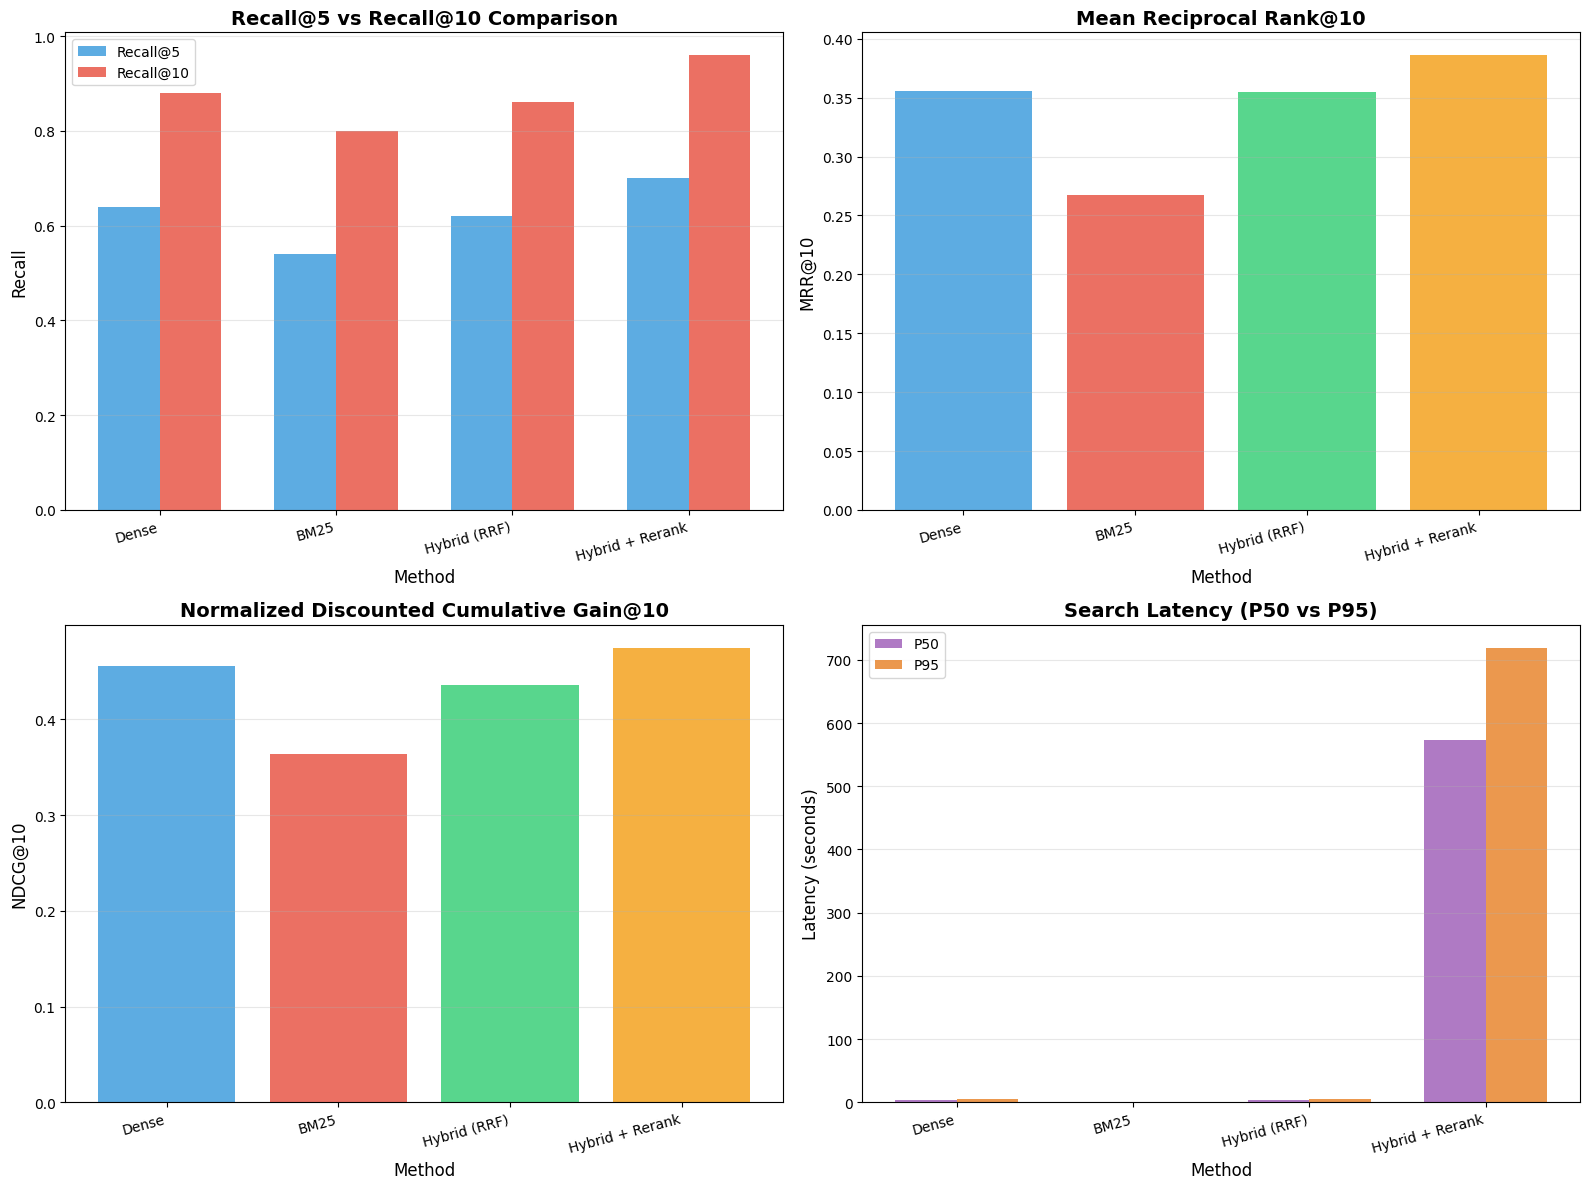

In [14]:
# 시각화
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

methods = metrics_summary['Method'].tolist()
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

# 1. Recall 비교
x = np.arange(len(methods))
width = 0.35
axes[0, 0].bar(x - width/2, metrics_summary['Recall@5'], width, label='Recall@5', color=colors[0], alpha=0.8)
axes[0, 0].bar(x + width/2, metrics_summary['Recall@10'], width, label='Recall@10', color=colors[1], alpha=0.8)
axes[0, 0].set_xlabel('Method', fontsize=12)
axes[0, 0].set_ylabel('Recall', fontsize=12)
axes[0, 0].set_title('Recall@5 vs Recall@10 Comparison', fontsize=14, fontweight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(methods, rotation=15, ha='right')
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. MRR@10
axes[0, 1].bar(methods, metrics_summary['MRR@10'], color=colors, alpha=0.8)
axes[0, 1].set_xlabel('Method', fontsize=12)
axes[0, 1].set_ylabel('MRR@10', fontsize=12)
axes[0, 1].set_title('Mean Reciprocal Rank@10', fontsize=14, fontweight='bold')
axes[0, 1].set_xticklabels(methods, rotation=15, ha='right')
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. NDCG@10
axes[1, 0].bar(methods, metrics_summary['NDCG@10'], color=colors, alpha=0.8)
axes[1, 0].set_xlabel('Method', fontsize=12)
axes[1, 0].set_ylabel('NDCG@10', fontsize=12)
axes[1, 0].set_title('Normalized Discounted Cumulative Gain@10', fontsize=14, fontweight='bold')
axes[1, 0].set_xticklabels(methods, rotation=15, ha='right')
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Latency
x = np.arange(len(methods))
axes[1, 1].bar(x - width/2, metrics_summary['Latency (P50)'], width, label='P50', color='#9b59b6', alpha=0.8)
axes[1, 1].bar(x + width/2, metrics_summary['Latency (P95)'], width, label='P95', color='#e67e22', alpha=0.8)
axes[1, 1].set_xlabel('Method', fontsize=12)
axes[1, 1].set_ylabel('Latency (seconds)', fontsize=12)
axes[1, 1].set_title('Search Latency (P50 vs P95)', fontsize=14, fontweight='bold')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(methods, rotation=15, ha='right')
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'metrics_comparison.png', dpi=300, bbox_inches='tight')
print(f"\n✅ Comparison plot saved to: {PLOTS_DIR / 'metrics_comparison.png'}")
plt.show()

✅ Improvement plot saved to: /home/dhc99/ajou-llmops-2025-2nd-semester/assignment02/results/plots/improvement_over_baseline.png


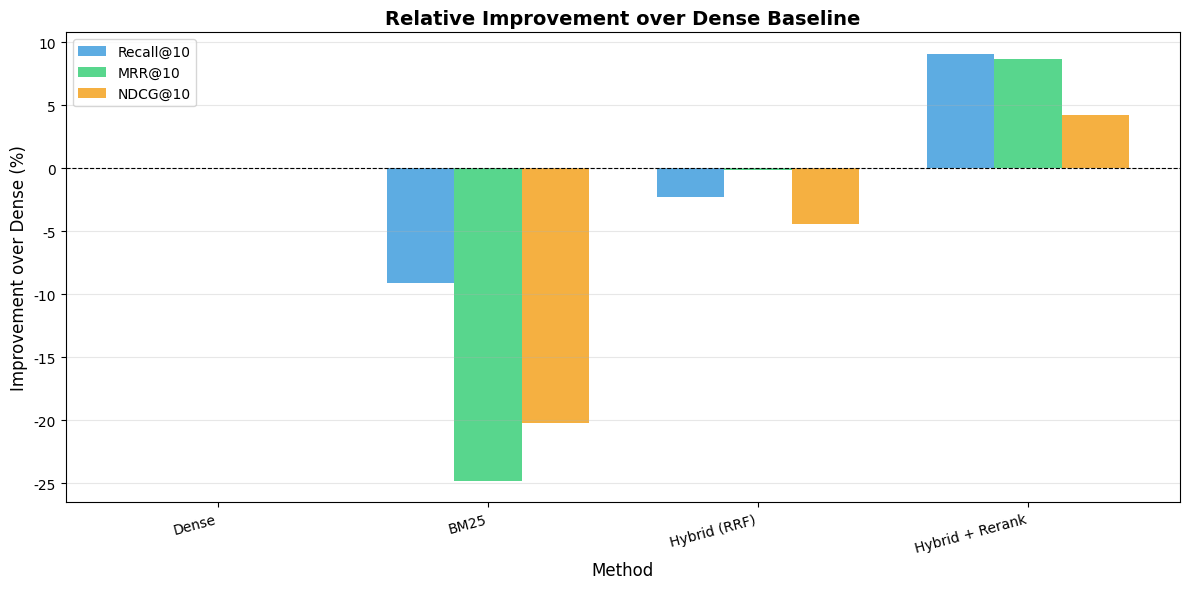


📊 Improvement over Dense Baseline:
         Method  Recall@10 Improvement  MRR@10 Improvement  NDCG@10 Improvement
          Dense               0.000000            0.000000             0.000000
           BM25              -9.090909          -24.812954           -20.220230
   Hybrid (RRF)              -2.272727           -0.111669            -4.389718
Hybrid + Rerank               9.090909            8.681184             4.252074


In [15]:
# 개선 폭 계산 및 시각화
baseline = metrics_summary[metrics_summary['Method'] == 'Dense'].iloc[0]

improvement_data = []
for _, row in metrics_summary.iterrows():
    improvement_data.append({
        'Method': row['Method'],
        'Recall@10 Improvement': (row['Recall@10'] - baseline['Recall@10']) / baseline['Recall@10'] * 100 if baseline['Recall@10'] > 0 else 0,
        'MRR@10 Improvement': (row['MRR@10'] - baseline['MRR@10']) / baseline['MRR@10'] * 100 if baseline['MRR@10'] > 0 else 0,
        'NDCG@10 Improvement': (row['NDCG@10'] - baseline['NDCG@10']) / baseline['NDCG@10'] * 100 if baseline['NDCG@10'] > 0 else 0
    })

improvement_df = pd.DataFrame(improvement_data)

# 개선 폭 플롯
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(methods))
width = 0.25

ax.bar(x - width, improvement_df['Recall@10 Improvement'], width, label='Recall@10', color='#3498db', alpha=0.8)
ax.bar(x, improvement_df['MRR@10 Improvement'], width, label='MRR@10', color='#2ecc71', alpha=0.8)
ax.bar(x + width, improvement_df['NDCG@10 Improvement'], width, label='NDCG@10', color='#f39c12', alpha=0.8)

ax.set_xlabel('Method', fontsize=12)
ax.set_ylabel('Improvement over Dense (%)', fontsize=12)
ax.set_title('Relative Improvement over Dense Baseline', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(methods, rotation=15, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8)

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'improvement_over_baseline.png', dpi=300, bbox_inches='tight')
print(f"✅ Improvement plot saved to: {PLOTS_DIR / 'improvement_over_baseline.png'}")
plt.show()

print("\n📊 Improvement over Dense Baseline:")
print(improvement_df.to_string(index=False))

## 6. 질적 분석 (Success & Failure Cases)

In [17]:
# 성공 및 실패 사례 분석
# NOTE: Avoid global name collision with `rerank_results` (dict) by using local helpers here.

def _local_rerank(query: str, results: List[Dict], top_k: int = 10) -> List[Dict]:
    """
    Local reranker to avoid calling the globally shadowed rerank_results.
    """
    if not results:
        return []

    pairs = [[query, r['text']] for r in results]
    scores = reranker_model.predict(pairs, batch_size=config['reranker']['batch_size'])

    decorated = []
    for i, r in enumerate(results):
        rr = r.copy()
        rr['rerank_score'] = float(scores[i])
        rr['original_score'] = float(r.get('score', 0.0))
        rr['score'] = float(scores[i])
        decorated.append(rr)

    return sorted(decorated, key=lambda x: x['rerank_score'], reverse=True)[:top_k]


def _local_hybrid_rerank_search(query: str, method: str = 'rrf', top_k: int = 10) -> List[Dict]:
    # Fetch candidates using existing hybrid_search, then rerank locally
    candidates = hybrid_search(
        query,
        method=method,
        top_k=config['reranker']['top_n']
    )
    return _local_rerank(query, candidates, top_k=top_k)


def analyze_quality_examples(eval_queries: pd.DataFrame, num_examples: int = 5):
    """
    질적 분석을 위한 성공/실패 사례 추출
    """
    examples = []

    for idx in range(min(num_examples, len(eval_queries))):
        query_row = eval_queries.iloc[idx]
        query = query_row['question']
        ground_truth = query_row['ground_truth_chunk_id']

        # 4가지 방법으로 검색
        dense_res = dense_search(query, top_k=5)
        bm25_res = bm25_search(query, top_k=5)
        hybrid_res = hybrid_search(query, method='rrf', top_k=5)
        # Use local hybrid+rerank to avoid global name collision
        rerank_res = _local_hybrid_rerank_search(query, method='rrf', top_k=5)

        # 정답 포함 여부
        dense_hit = ground_truth in [r['chunk_id'] for r in dense_res]
        bm25_hit = ground_truth in [r['chunk_id'] for r in bm25_res]
        hybrid_hit = ground_truth in [r['chunk_id'] for r in hybrid_res]
        rerank_hit = ground_truth in [r['chunk_id'] for r in rerank_res]

        example = {
            'query': query,
            'ground_truth_answer': query_row['ground_truth_answer'],
            'dense_hit': dense_hit,
            'bm25_hit': bm25_hit,
            'hybrid_hit': hybrid_hit,
            'rerank_hit': rerank_hit,
            'dense_top1': dense_res[0]['text'][:200] if dense_res else 'N/A',
            'rerank_top1': rerank_res[0]['text'][:200] if rerank_res else 'N/A'
        }

        examples.append(example)

    return examples


# 사례 분석
quality_examples = analyze_quality_examples(eval_queries_df, num_examples=10)

# Markdown 파일로 저장
with open(RESULTS_DIR / 'qual_examples.md', 'w', encoding='utf-8') as f:
    f.write("# Quality Analysis: Success & Failure Cases\n\n")

    for i, ex in enumerate(quality_examples, 1):
        f.write(f"## Example {i}\n\n")
        f.write(f"**Query:** {ex['query']}\n\n")
        f.write(f"**Ground Truth Answer:** {ex['ground_truth_answer']}\n\n")

        f.write("### Results:\n\n")
        f.write(f"- Dense: {'✅ HIT' if ex['dense_hit'] else '❌ MISS'}\n")
        f.write(f"- BM25: {'✅ HIT' if ex['bm25_hit'] else '❌ MISS'}\n")
        f.write(f"- Hybrid: {'✅ HIT' if ex['hybrid_hit'] else '❌ MISS'}\n")
        f.write(f"- Hybrid+Rerank: {'✅ HIT' if ex['rerank_hit'] else '❌ MISS'}\n\n")

        f.write("### Top-1 Retrieved (Dense):\n")
        f.write(f"```\n{ex['dense_top1']}...\n```\n\n")

        f.write("### Top-1 Retrieved (Hybrid+Rerank):\n")
        f.write(f"```\n{ex['rerank_top1']}...\n```\n\n")

        # 원인 분석
        if ex['rerank_hit'] and not ex['dense_hit']:
            f.write("**✨ Success Case:** Hybrid+Rerank successfully retrieved the answer!\n")
            f.write("**Reason:** Likely due to better fusion and reranking.\n\n")
        elif not ex['rerank_hit']:
            f.write("**⚠️ Failure Case:** All methods failed to retrieve the answer.\n")
            f.write("**Possible Reasons:** Chunking issue, vocabulary mismatch, or complex query.\n\n")

        f.write("---\n\n")

print(f"\n✅ Quality examples saved to: {RESULTS_DIR / 'qual_examples.md'}")


✅ Quality examples saved to: /home/dhc99/ajou-llmops-2025-2nd-semester/assignment02/results/qual_examples.md


## 7. 최종 요약

In [18]:
print("\n" + "="*80)
print("🎉 Assignment 02 - Search & Evaluation Complete!")
print("="*80)

print("\n📊 Final Metrics Summary:")
print(metrics_summary.to_string(index=False))

print("\n📁 Generated Files:")
print(f"  - {RESULTS_DIR / 'metrics.csv'}")
print(f"  - {PLOTS_DIR / 'metrics_comparison.png'}")
print(f"  - {PLOTS_DIR / 'improvement_over_baseline.png'}")
print(f"  - {RESULTS_DIR / 'qual_examples.md'}")

print("\n📝 Next Steps:")
print("  1. Review quality examples in qual_examples.md")
print("  2. Analyze failure cases and improvement opportunities")
print("  3. Create PDF report with findings")
print("  4. Invite instructor to Pinecone project")
print("  5. Submit all deliverables")

print("\n" + "="*80)


🎉 Assignment 02 - Search & Evaluation Complete!

📊 Final Metrics Summary:
         Method  Recall@5  Recall@10   MRR@10  NDCG@10  Latency (P50)  Latency (P95)
          Dense      0.64       0.88 0.355357 0.455610       3.945591       5.383369
           BM25      0.54       0.80 0.267183 0.363485       0.005177       0.017742
   Hybrid (RRF)      0.62       0.86 0.354960 0.435610       3.903644       5.404617
Hybrid + Rerank      0.70       0.96 0.386206 0.474983     572.790959     719.366606

📁 Generated Files:
  - /home/dhc99/ajou-llmops-2025-2nd-semester/assignment02/results/metrics.csv
  - /home/dhc99/ajou-llmops-2025-2nd-semester/assignment02/results/plots/metrics_comparison.png
  - /home/dhc99/ajou-llmops-2025-2nd-semester/assignment02/results/plots/improvement_over_baseline.png
  - /home/dhc99/ajou-llmops-2025-2nd-semester/assignment02/results/qual_examples.md

📝 Next Steps:
  1. Review quality examples in qual_examples.md
  2. Analyze failure cases and improvement opportuniti